# Core Ideas of this notebook
We just want to understand if we can fill in patches in a diffusion model using off-the-shelf diffusion models. Specifically, can we fill in black squares? Can we remove blobs of noise? We also test can we literally oerlay images and then just diffuse towards something more realistic?

This is imporant because if an off-the-self diffusion model can't do in-painting or diffusion of overlaid images (in any space) then it won't work to do this iterative "image tinkering" that I want to do with my model.

In [2]:
import torch
from diffusers import StableDiffusion3Pipeline
import gc
""" Check that stale diffusion works OK """
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda:2")

image = pipe(
    "A capybara holding a sign that reads Hello World",
    num_inference_steps=28,
    guidance_scale=3.5,
).images[0]
# image.save("capybara.png")
# del pipe, image
# gc.collect()
# torch.cuda.empty_cache()


/mnt/align3_drive/adrianoh/miniconda3/envs/diffusion_iap2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 28/28 [00:04<00:00,  6.33it/s]


In [28]:
# pipe

StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/stable-diffusion-3.5-medium",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

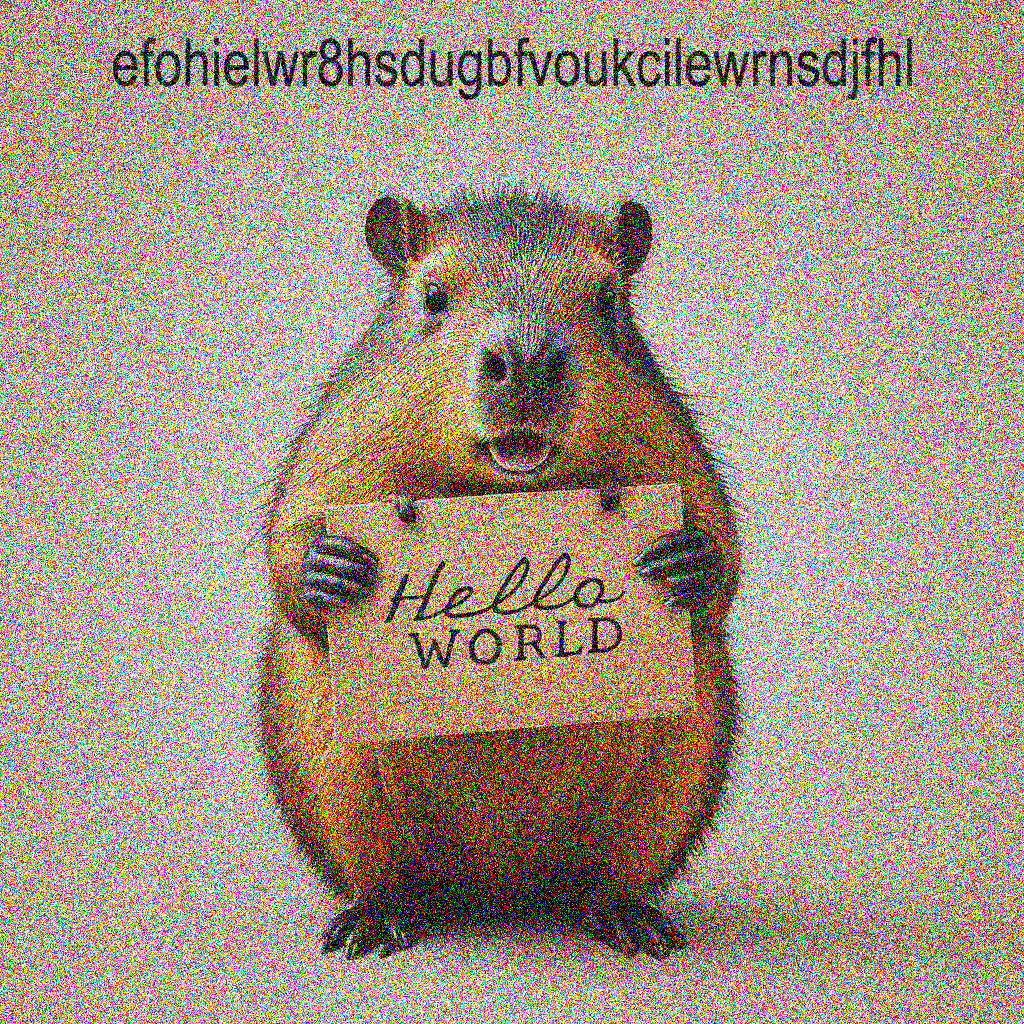

NameError: name 'pipe' is not defined

In [23]:
""" Try to get some images and then overlay them and get a vibe check for whether the generation is OK."""
# print(pipe)
# pipe.__dict__
from PIL import Image
import numpy as np
import IPython.display as display

# Open and display the image
img_letters = Image.open("random_letters.png")
img_capybara = Image.open("capybara.png")

# Convert to RGBA and make white pixels transparent, then resize and overlay
img_letters = img_letters.convert('RGBA') # ...
img_letters.putdata([(p[0], p[1], p[2], 0) if all(c > 250 for c in p[:3]) else p for p in img_letters.getdata()]) # Make white pixels transparent
img_letters = img_letters.resize((int(img_capybara.width * 0.8), int(img_letters.height * 0.8) - 10)) # Resize
# Create a copy of the capybara image and paste the letters on top
img_combined = img_capybara.copy()
# Calculate position to center letters horizontally and place near top vertically
x_pos = (img_capybara.width - img_letters.width) // 2
y_pos = 20
# Paste the letters onto the capybara image, using the alpha channel as mask
img_combined.paste(img_letters, (x_pos, y_pos), img_letters)
# Add Gaussian noise to the PIL image
noisy_image = Image.fromarray(np.clip(np.array(img_combined) + 10 * np.random.normal(loc=0, scale=10, size=np.array(img_combined).shape), 0, 255).astype(np.uint8))
#### EXAMPLE of adding noise differentially do different parts of the image ####
# height = np.array(img_combined).shape[0]
# noise_mask = np.tile(np.linspace(1, 0, height)[:, np.newaxis, np.newaxis], (1, np.array(img_combined).shape[1], 3)) #
# extra_noise = 200 * noise_mask * np.random.normal(loc=0, scale=10, size=np.array(img_combined).shape)
# noisy_image = Image.fromarray(np.clip(np.array(img_combined) + 10 * np.random.normal(loc=0, scale=10, size=np.array(img_combined).shape) + extra_noise, 0, 255).astype(np.uint8))

# display.display(img_letters)
# display.display(img_capybara)
# display.display(img_combined) # <----- should display the overlaid image
display.display(noisy_image)

# XXX how to diffuse an image using stablediffusion?



In [4]:
""" Generate some possible images with signs that we will put text on """
from pathlib import Path
import tqdm
assert not Path("signs_semimanual").exists() or len(list(Path("signs_semimanual").glob("*"))) == 0
Path("signs_semimanual").mkdir(exist_ok=True, parents=True)
# pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
# pipe = pipe.to("cuda:2")
num_images_per_batch = 8
for j in tqdm.trange(10, desc="Generating signs (batch loop)"):
    images= pipe(
        "A photo from the middle of a city with a sign with no text on it. The sign has NO text on it. It is BLANK.",
        num_inference_steps=28,
        guidance_scale=3.5,
        num_images_per_prompt=num_images_per_batch,
    ).images
    for i, image in enumerate(images):
        image.save(f"signs_semimanual/image{j*num_images_per_batch + i}.png")


  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:32<00:00,  1.15s/it]

In [33]:
from PIL import Image, ImageDraw, ImageFont
import random, string, math

def generate_random_text_image(
        # Lines guidance
        min_num_lines: int = 1,
        max_num_lines: int = 10,
        min_line_length: int = 2,
        max_line_length: int = 20,
        # Image guidance
        img_width: int = 512,
        img_height: int = 512,
        # Font guidance
        font_path: str = "DejaVuSans.ttf", # XXX ?1?!?!?
        base_font_size: int = 40, # XXX ?!?!
    ):
    # chars = string.ascii_letters + "!@#$%^&*(){}|[]\\;':\",./<>?`~"
    # lines = [''.join(random.choice(chars) for _ in range(int(math.exp(random.uniform(math.log(2), math.log(20)))))) for _ in range(random.randint(1, 10))]
    # img, draw = Image.new('RGB', (width, height), 'white'), ImageDraw.Draw(Image.new('RGB', (width, height), 'white'))
    # font = ImageFont.truetype(font_path, base_font_size) if font_path else ImageFont.load_default()
    # [draw.text(((width - draw.textsize(line, font=font)[0])/2, i * height/len(lines)), line, fill='black', font=font) for i, line in enumerate(lines)]
    # return img
    raise NotImplementedError("Not implemented") # XXX this has to be finished!

